<h1 style="text-align:center">Income Prediction</h1>

### This work consists on the analysis of a dataset containing data from thousands of fictional people. The objective of the analysis and modelling is to predict the income (renda) of the subject. 

### Note that the Dataset was originally available in portuguese

| Variable                | Description                                           | Type         |
| ----------------------- |:---------------------------------------------------:| ------------:|
| data_ref                |  Date of data collection                              | datetime|
| id_cliente              |  Unique customer ID                                   | int|
| sexo                    |  Customer's gender                                    | object|
| posse_de_veiculo        |  Owns a vehicle or not                                | bool|
| posse_de_imovel         |  Owns property or not                                 | bool|
| qtd_filhos              |  Number of children the customer has                  | int|
| tipo_renda              |  Income type: Entrepreneur, Salaried, Public Servant, Pensioner, or Scholar | object|
| educacao                |  Education level: Primary, Secondary, Incomplete Higher, Complete Higher, or Postgraduate | object|
| estado_civil            |  Marital status: Single, Married, Widowed, Union, or Separated | object|
| tipo_residencia         |  Residence type: House, Governmental, With parents, Rent, Studio, or Communal | object|
| idade                   |  Customer's age                                       | int|
| tempo_emprego           |  Customer's employment duration (in years)            | float|
| qt_pessoas_residencia   |  Number of people living in the customer's residence  | float|
| renda                   |  Customer's income (Dependent variable)               | float|


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.read_csv('./Data/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [6]:
plt.style.use('ggplot')

## Basic data cleaning

In [8]:
df.dtypes

data_ref                  object
index                      int64
sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

In [9]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [10]:
average_tempo_emprego = df['tempo_emprego'].mean()
df.loc[:, 'tempo_emprego'] = df['tempo_emprego'].fillna(average_tempo_emprego)

## Creating auxiliary variables to explain possible underlying patterns

In [12]:
df['tempo_emprego_idade_ratio'] = df['tempo_emprego'] / df['idade']
df['tempo_emprego_idade_ratio']

0         0.355698
1         0.320000
2         0.293151
3         0.029577
4         0.038024
            ...   
749995    0.298819
749996    0.119172
749997    0.332420
749998    0.293542
749999    0.124938
Name: tempo_emprego_idade_ratio, Length: 750000, dtype: float64

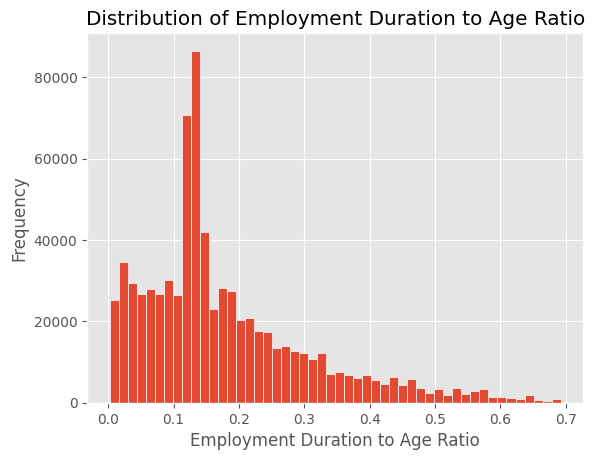

In [13]:
plt.hist(df['tempo_emprego_idade_ratio'], bins=50, edgecolor='w')
plt.xlabel('Employment Duration to Age Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Employment Duration to Age Ratio')
plt.show()

In [14]:
df['log_renda'] = np.log(df['renda'])

## Train/Test split, with 80% of the data being allocated for Training and 20% for Testing

In [16]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=99)

## Correlation study

In [19]:
correlation_matrix = (
    train_data
    .select_dtypes(include='number')
    .corr()
)

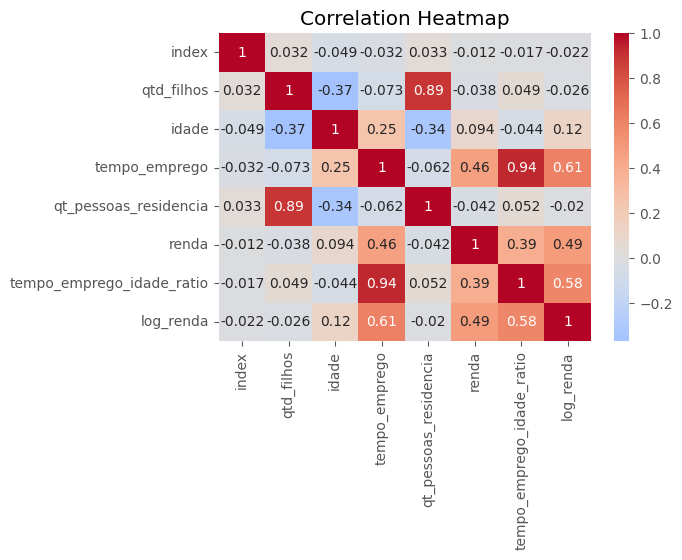

In [20]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

#### Cramer's V

##### It is a measure of association between two categorical variables

$$ V = \sqrt{\frac{\chi^2}{n \times (\min(r, k) - 1)}} $$

-  V : Cramér's V, the measure of association between two categorical variables.
-  $\chi^2 $: The Chi-Square statistic, calculated from the contingency table of the two categorical variables.
-  n : The total number of observations in the dataset.
-  r : The number of rows in the contingency table.
-  k : The number of columns in the contingency table.
- $min(r, k)$: The minimum of the number of rows and columns in the contingency table, used to adjust the degrees of freedom.

In [22]:

def cramers_v(confusion_matrix):
    if confusion_matrix.size == 0:
        return np.nan
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v_matrix(data, exclude_var):
    # Select only the categorical variables, excluding the continuous target variable
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    categorical_data = data[categorical_cols]
    
    # Initialize the matrix
    n = len(categorical_cols)
    cramers_v_matrix = pd.DataFrame(np.zeros((n, n)), index=categorical_cols, columns=categorical_cols)
    
    # Compute Cramér's V for each pair of categorical variables
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 != col2:
                confusion_matrix = pd.crosstab(categorical_data[col1], categorical_data[col2])
                cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)
            else:
                cramers_v_matrix.loc[col1, col2] = np.nan
    
    return cramers_v_matrix

In [23]:
cramers_matrix = cramers_v_matrix(train_data, exclude_var='log_renda')

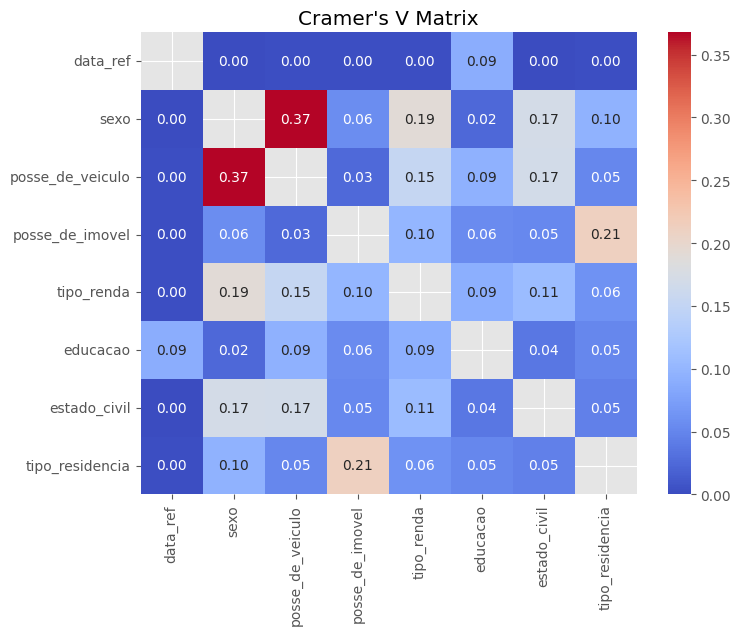

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramer\'s V Matrix')
plt.show()

### Let's train a model on the 'tempo_emprego_idade_ratio' in order to predict 'log_renda'

In [26]:
reg_ratio = smf.ols('''log_renda ~ 
    tempo_emprego_idade_ratio
    ''', data=train_data).fit()

In [27]:
reg_ratio.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                 3.088e+05
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:16:00   Log-Likelihood:            -8.7705e+05
No. Observations:              600000   AIC:                         1.754e+06
Df Residuals:                  599998   BIC:                         1.754e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     8.0228      0.002   3523.573      0.000       8.018       8.027
tempo_emprego_idade_ratio     5.7188      0.010    555.699      0.000       5.699       5.739
==============================================================================
Omnibus:                     1924.795   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1480.507
Skew:                          -0.011   Prob(JB):                         0.00
Kurtosis:                       2.758   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sampling the data for performance purposes

In [29]:
sampled_data = train_data.sample(n=7000, random_state=105)

<Axes: xlabel='tempo_emprego_idade_ratio', ylabel='log_renda'>

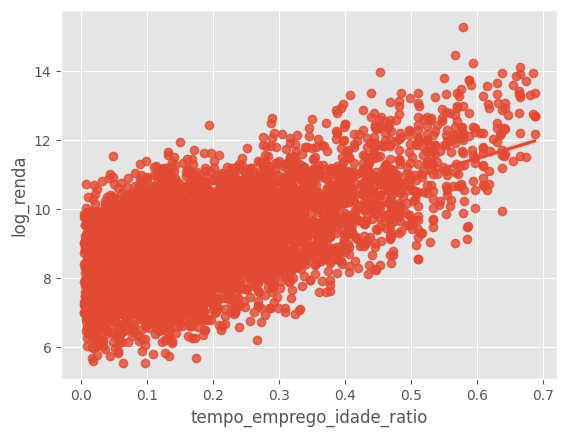

In [30]:
sns.regplot(y='log_renda', x='tempo_emprego_idade_ratio', data=sampled_data)

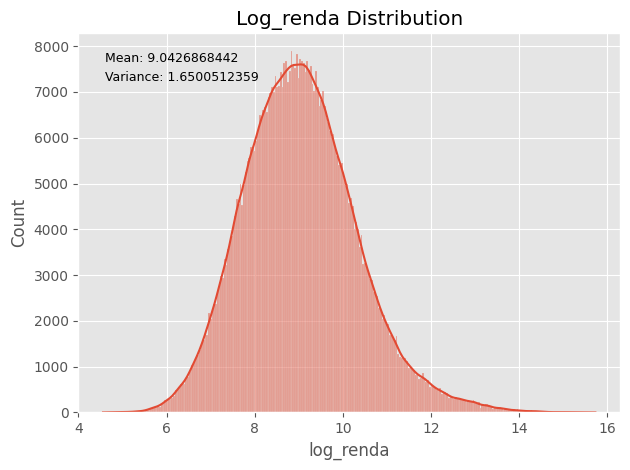

In [31]:
mean_log_renda = train_data['log_renda'].mean()
var_log_renda = train_data['log_renda'].var()

sns.histplot(train_data['log_renda'], kde=True)
plt.title('Log_renda Distribution')
plt.text(0.05, 0.95, f"Mean: {mean_log_renda:.10f}", transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.05, 0.90, f"Variance: {var_log_renda:.10f}", transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.tight_layout()
plt.show()

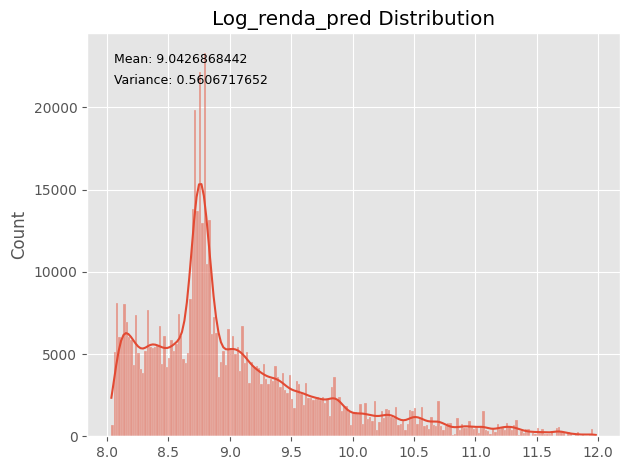

In [32]:
mean_log_renda_pred = reg_ratio.predict(train_data).mean()
var_log_renda_pred = reg_ratio.predict(train_data).var()

sns.histplot(reg_ratio.predict(train_data), kde=True)
plt.title('Log_renda_pred Distribution')
plt.text(0.05, 0.95, f"Mean: {mean_log_renda_pred:.10f}", transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.text(0.05, 0.90, f"Variance: {var_log_renda_pred:.10f}", transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.tight_layout()
plt.show()

In [33]:
def residual_plots(reg, data, y_var): # A function to plot the residuals
    predicted_values = reg.predict(data)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    mean_resid = reg.resid.mean()
    var_resid = reg.resid.var()
    
    # Residual plot
    sns.residplot(x=predicted_values, y=y_var, data=data, lowess=True, 
                  scatter_kws={'alpha': 0.5}, 
                  line_kws={'color': 'blue', 'lw': 2}, 
                  ax=axs[0])
    axs[0].set_title('Residual Plot')
    
    # Residual distribution plot
    sns.histplot(reg.resid, kde=True, ax=axs[1])
    axs[1].set_title('Residual Distribution')
    axs[1].text(0.05, 0.95, f"Mean Residual: {mean_resid:.10f}", transform=axs[1].transAxes, fontsize=9, verticalalignment='top')
    axs[1].text(0.05, 0.90, f"Variance of Residuals: {var_resid:.10f}", transform=axs[1].transAxes, fontsize=9, verticalalignment='top')
    plt.tight_layout()
    plt.show()

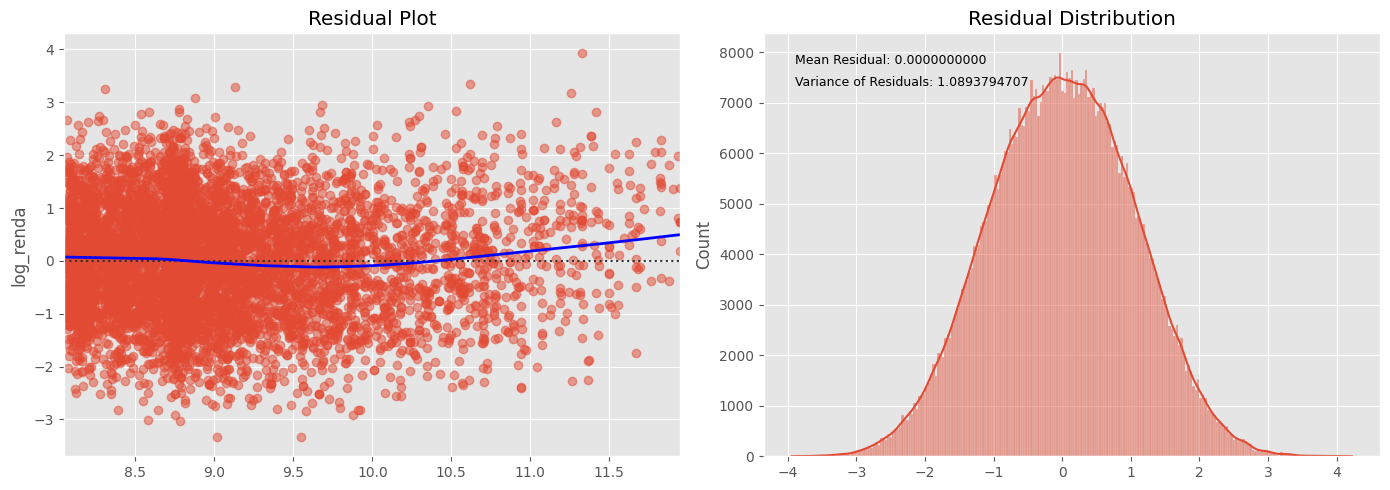

In [34]:
residual_plots(reg_ratio, sampled_data, 'log_renda')

### ^ The pattern followed by the residuals is satisfactory when it comes to the variance, but it tends to form a cluster to the left of the plot. The residuals follow the normal distribution perfectly, considering that the mean is 0 and the variance is 1.

In [36]:
date_resid = pd.DataFrame({
    'data_ref': train_data['data_ref'],
    'res': reg_ratio.resid
})

date_resid_gp = date_resid.groupby('data_ref')['res'].mean().reset_index()

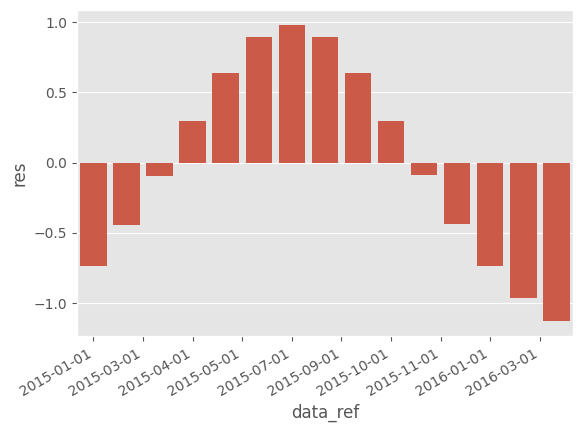

In [37]:
sns.barplot(x='data_ref', y='res', data=date_resid_gp)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of x-ticks
plt.gcf().autofmt_xdate()  # Auto format the date labels

### ^ The average residual value is related with the month of reference

### Now, let's perform the same analysis on the residuals of other numeric variables

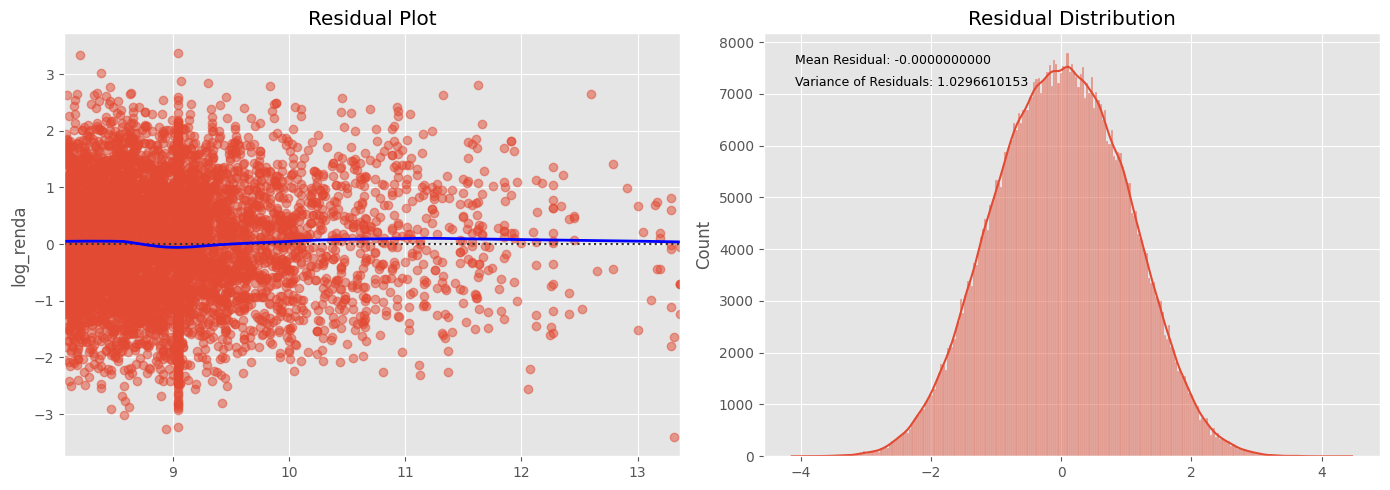

In [40]:
reg_t_temprego = smf.ols('''log_renda ~ 
    tempo_emprego
    ''', data=train_data).fit()

residual_plots(reg_t_temprego, sampled_data, 'log_renda')

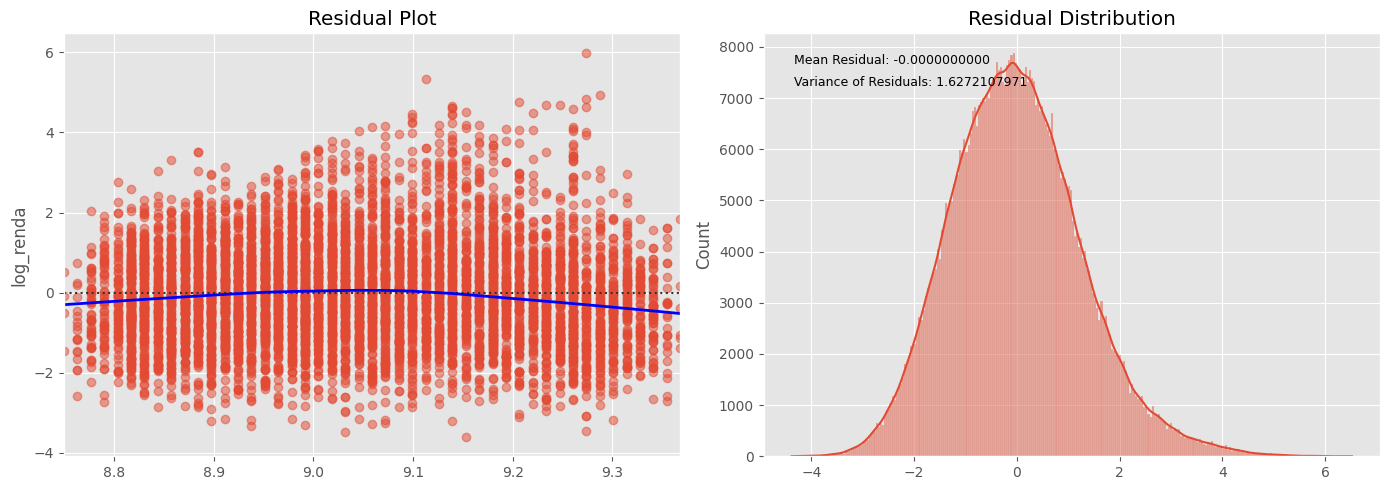

In [41]:
reg_idade = smf.ols('''log_renda ~ 
    idade
    ''', data=train_data).fit()

residual_plots(reg_idade, sampled_data, 'log_renda')

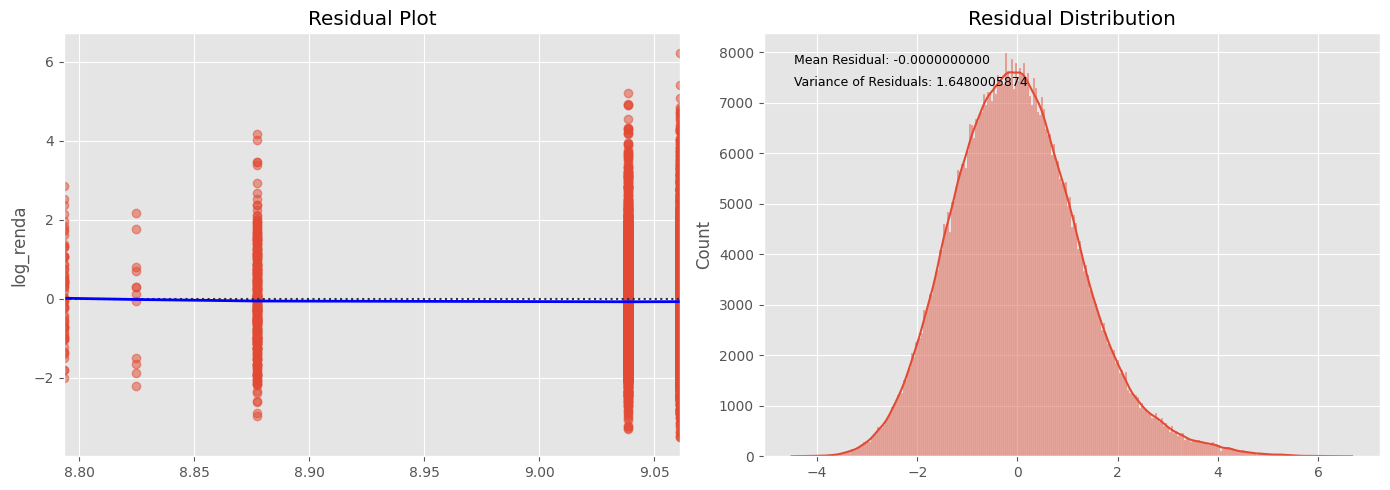

In [42]:
reg_educacao = smf.ols('''log_renda ~ 
    educacao
    ''', data=train_data).fit()

residual_plots(reg_educacao, sampled_data, 'log_renda')

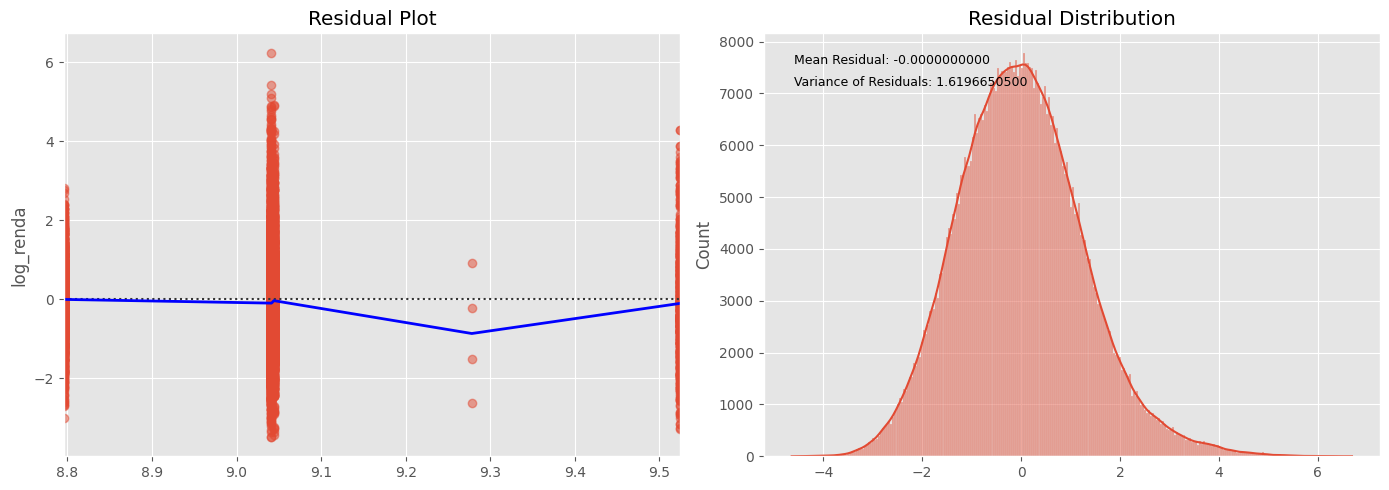

In [43]:
reg_tipo_renda = smf.ols('''log_renda ~ 
    tipo_renda
    ''', data=train_data).fit()

residual_plots(reg_tipo_renda, sampled_data, 'log_renda')

### Now, we are going to train a model on some important variables and then verify the studentized residuals

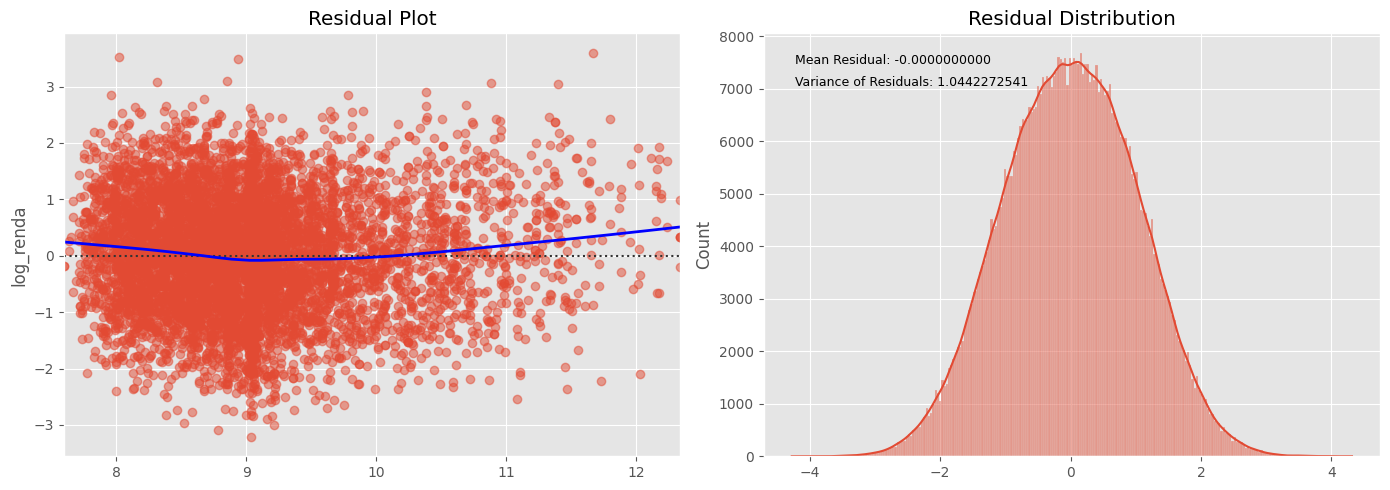

In [46]:
reg1 = smf.ols('''log_renda ~ 
    tempo_emprego_idade_ratio +
    idade +
    educacao +
    posse_de_veiculo +
    posse_de_imovel +
    sexo + 
    qt_pessoas_residencia
    ''', data=train_data).fit()

residual_plots(reg1, sampled_data, 'log_renda')

In [47]:
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 3.481e+04
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:16:48   Log-Likelihood:            -8.6435e+05
No. Observations:              600000   AIC:                         1.729e+06
Df Residuals:                  599989   BIC:                         1.729e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           6.9893      0.015    467.651      0.000       6.960       7.019
educacao[T.Médio]                   0.1453      0.012     11.648      0.000       0.121       0.170
educacao[T.Pós graduação]           0.2407      0.041      5.827      0.000       0.160       0.322
educacao[T.Superior completo]       0.1595      0.013     12.685      0.000       0.135       0.184
educacao[T.Superior incompleto]     0.1248      0.014      8.840      0.000       0.097       0.153
posse_de_veiculo[T.S]               0.0269      0.003      9.139      0.000       0.021       0.033
posse_de_imovel[T.S]                0.1841      0.003     64.830      0.000       0.179       0.190
sexo[T.M]                           0.1246      0.003     40.385      0.000       0.119       0.131
tempo_emprego_idade_ratio           5.8368      0.010    575.799      0.000       5.817       5.857
idade                               0.0165      0.000    125.649      0.000       0.016       0.017
qt_pessoas_residencia              -0.0140      0.002     -8.945      0.000      -0.017      -0.011
==============================================================================
Omnibus:                     2443.455   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1821.751
Skew:                          -0.013   Prob(JB):                         0.00
Kurtosis:                       2.731   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
correlation_matrix_spearman = (
    train_data
    .select_dtypes(include='number')
    .corr(method='spearman')
)

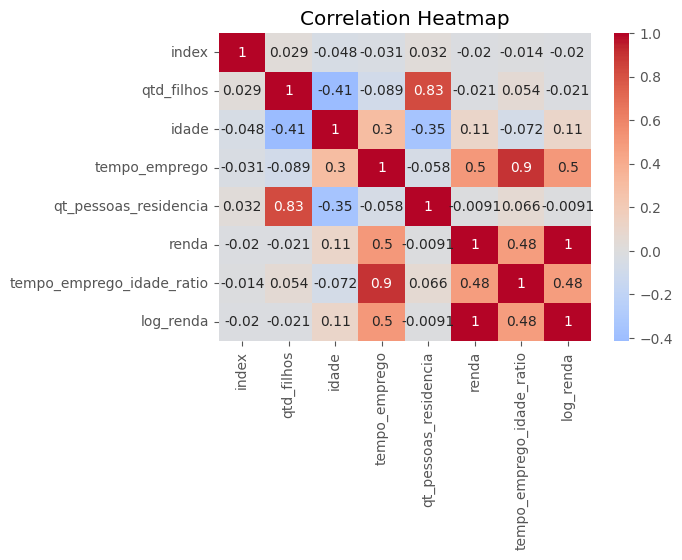

In [50]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

### VIF

In [52]:
vars = train_data.drop(columns=['data_ref', 'index', 'renda', 'log_renda'])
vars_cat = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

In [53]:
train_data_dum = pd.get_dummies(vars[vars_cat], drop_first=True)
train_data_dum = train_data_dum.map(lambda x: 1 if x is True else (0 if x is False else x))

In [54]:
vars.drop(columns=vars_cat, inplace=True)
vif_df = pd.concat([vars, train_data_dum], axis=1, ignore_index=False)

In [55]:
vars_vif = pd.DataFrame()

vars_vif["VIF Factor"] = [vif(vif_df, i) for i in range(vif_df.shape[1])]
vars_vif["Feature"] = vif_df.columns

vars_vif.round(2)

,VIF Factor,Feature
0,74.69,idade
1,68.85,tempo_emprego
2,288.16,qt_pessoas_residencia
3,69.63,tempo_emprego_idade_ratio
4,40.18,qtd_filhos
5,1.82,sexo_M
6,1.97,posse_de_veiculo_S
7,3.24,posse_de_imovel_S
8,1.00,tipo_renda_Bolsista
9,1.48,tipo_renda_Empresário


### The VIF is very high in some of the variables. We are going to turn some variables into orthogonal variables, perform some cleanup and check the result again

In [57]:
means1 = train_data['tempo_emprego'].groupby(train_data['educacao']).mean()
train_data['tempo_emprego_ort'] = train_data['tempo_emprego'] - train_data['educacao'].map(means1)

means2 = train_data['idade'].groupby(train_data['educacao']).mean()
train_data['idade_ort'] = train_data['tempo_emprego'] - train_data['educacao'].map(means2)

In [58]:
vars = train_data.drop(columns=['qt_pessoas_residencia', 'tempo_emprego_idade_ratio', 'data_ref', 'index', 'renda', 'log_renda'])
vif_df = pd.concat([vars, train_data_dum], axis=1, ignore_index=False)

In [59]:
vars.drop(columns=vars_cat, inplace=True)
vif_df = pd.concat([vars, train_data_dum], axis=1, ignore_index=False)

In [60]:
vars_vif = pd.DataFrame()

vars_vif["VIF Factor"] = [vif(vif_df, i) for i in range(vif_df.shape[1])]
vars_vif["Feature"] = vif_df.columns

vars_vif.round(2)

C:\Users\Hanga\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Feature
0,2.16,idade
1,inf,tempo_emprego
2,inf,tempo_emprego_ort
3,inf,idade_ort
4,1.21,qtd_filhos
5,1.23,sexo_M
6,1.20,posse_de_veiculo_S
7,1.07,posse_de_imovel_S
8,1.00,tipo_renda_Bolsista
9,1.14,tipo_renda_Empresário


In [61]:
train_data.drop(columns=['qt_pessoas_residencia', 'tempo_emprego_idade_ratio', 'data_ref', 'index', 'renda'], inplace=True)

In [62]:
train_data

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,log_renda,tempo_emprego_ort,idade_ort
430929,F,S,N,2,Assalariado,Médio,Casado,Casa,33,5.268493,9.239513,-2.675817,-39.986615
5824,F,N,N,0,Servidor público,Médio,União,Casa,35,15.282192,8.609088,7.337881,-29.972916
336875,F,N,S,0,Pensionista,Médio,União,Casa,54,7.746165,8.937955,-0.198146,-37.508943
568081,M,N,S,1,Assalariado,Superior completo,Casado,Casa,25,3.383562,8.554822,-4.211441,-38.726753
108996,M,S,N,0,Assalariado,Superior completo,Casado,Casa,32,1.758904,7.924423,-5.836098,-40.351411
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239305,F,S,S,0,Servidor público,Superior completo,Separado,Casa,52,5.219178,9.163380,-2.375824,-36.891137
691368,F,N,N,1,Assalariado,Médio,União,Casa,41,9.589041,7.994474,1.644731,-35.666067
177337,M,N,S,0,Assalariado,Superior completo,Casado,Casa,37,10.863014,9.657408,3.268011,-31.247301
547875,F,N,S,0,Empresário,Médio,Casado,Casa,43,15.972603,10.867246,8.028292,-29.282505


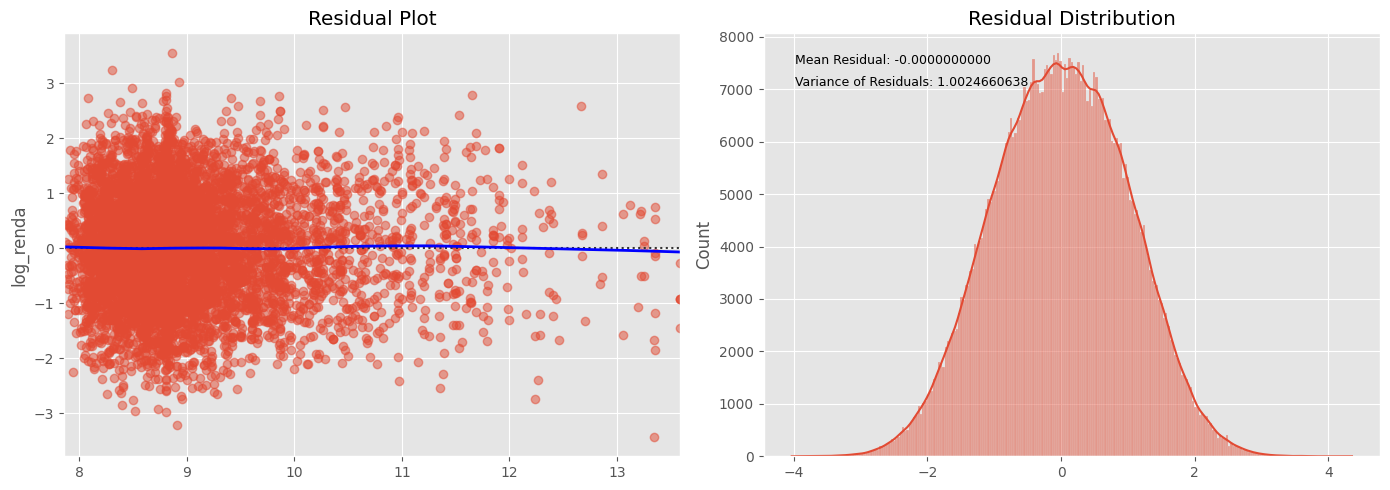

In [63]:
reg2 = smf.ols('''log_renda ~ 
    idade +
    posse_de_veiculo +
    posse_de_imovel +
    sexo + 
    qtd_filhos +
    tipo_renda +
    tipo_residencia +
    tempo_emprego_ort +
    idade_ort
    ''', data=train_data).fit()

sampled_data = train_data.sample(n=7000, random_state=105)

residual_plots(reg2, sampled_data, 'log_renda')

In [64]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                 2.422e+04
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:17:53   Log-Likelihood:            -8.5210e+05
No. Observations:              600000   AIC:                         1.704e+06
Df Residuals:                  599983   BIC:                         1.704e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.1578      0.026    313.082      0.000       8.107       8.209
posse_de_veiculo[T.S]                0.0159      0.003      5.511      0.000       0.010       0.021
posse_de_imovel[T.S]                 0.1880      0.003     66.286      0.000       0.182       0.194
sexo[T.M]                            0.1246      0.003     41.033      0.000       0.119       0.131
tipo_renda[T.Bolsista]              -0.1809      0.057     -3.182      0.001      -0.292      -0.069
tipo_renda[T.Empresário]             0.1550      0.003     47.405      0.000       0.149       0.161
tipo_renda[T.Pensionista]           -0.3024      0.005    -65.149      0.000      -0.312      -0.293
tipo_renda[T.Servidor público]       0.1445      0.005     30.062      0.000       0.135       0.154
tipo_residencia[T.Casa]             -0.0690      0.011     -6.215      0.000      -0.091      -0.047
tipo_residencia[T.Com os pais]      -0.0365      0.013     -2.895      0.004      -0.061      -0.012
tipo_residencia[T.Comunitário]      -0.1136      0.022     -5.069      0.000      -0.158      -0.070
tipo_residencia[T.Estúdio]          -0.1176      0.019     -6.267      0.000      -0.154      -0.081
tipo_residencia[T.Governamental]    -0.0817      0.013     -6.171      0.000      -0.108      -0.056
idade                                0.0039      0.000     23.290      0.000       0.004       0.004
qtd_filhos                           0.0035      0.002      1.862      0.063      -0.000       0.007
tempo_emprego_ort                    0.1459      0.001    206.855      0.000       0.145       0.147
idade_ort                           -0.0169      0.001    -25.811      0.000      -0.018      -0.016
==============================================================================
Omnibus:                     3190.089   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2302.305
Skew:                          -0.025   Prob(JB):                         0.00
Kurtosis:                       2.701   Cond. No.                     2.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### We can notice a significant improvement with the adjustments we made.

### Evaluating our data in the test set

#### (Performing all transformations )

In [68]:
means1_test = test_data['tempo_emprego'].groupby(test_data['educacao']).mean()
test_data['tempo_emprego_ort'] = test_data['tempo_emprego'] - test_data['educacao'].map(means1_test)

means2_test = test_data['idade'].groupby(test_data['educacao']).mean()
test_data['idade_ort'] = test_data['tempo_emprego'] - test_data['educacao'].map(means2_test)

In [69]:
from sklearn.metrics import r2_score
r_squared_test = r2_score(test_data['log_renda'], reg2.predict(test_data))

In [70]:
r_squared_test

0.39284080244555664

### Now, we are going to try a lowess approach on top of a PCA.

In [73]:
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()
X = train_data.drop(columns=['log_renda'])
X_cat = X[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']]
X_dum = pd.get_dummies(X_cat, drop_first=True)

In [75]:
X_dum = X_dum.map(lambda x: 1 if x is True else (0 if x is False else x))
X.drop(columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], inplace=True)

In [76]:
X_pca = pd.concat([X, X_dum], axis=1, ignore_index=False)

In [77]:
scaled_X = scaler.fit_transform(X)

In [78]:
scaled_data = scaler.fit_transform(X_pca)
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_X)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

In [79]:
def plot_cumulative_explained_variance(pca):
    # Calculate explained variance and cumulative explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()
    
    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend(loc='best')
    plt.show()

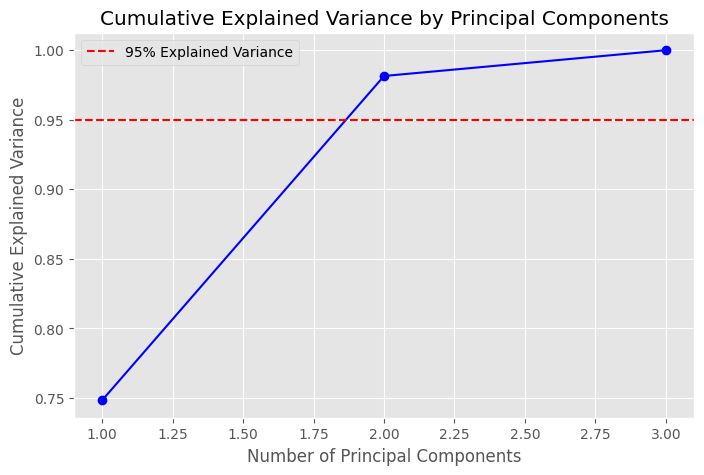

In [80]:
plot_cumulative_explained_variance(pca)

In [81]:
pca_df.index = train_data.index

In [82]:
pca_df['log_renda'] = train_data['log_renda']
pca_df

,PC1,PC2,PC3,log_renda
430929,-1.006571,-0.771640,-0.225476,9.239513
5824,1.778087,-1.120425,-0.281250,8.609088
336875,0.025795,0.930322,-0.107754,8.937955
568081,-1.352808,-1.457311,0.114074,8.554822
108996,-1.681950,-0.761952,0.170103,7.924423
...,...,...,...,...
239305,-0.396368,0.801460,0.274680,9.163380
691368,0.314420,-0.299701,-0.203763,7.994474
177337,0.903043,-0.801580,0.139803,9.657408
547875,2.101733,-0.458815,-0.234667,10.867246


### Now, let's train a model on top of this data

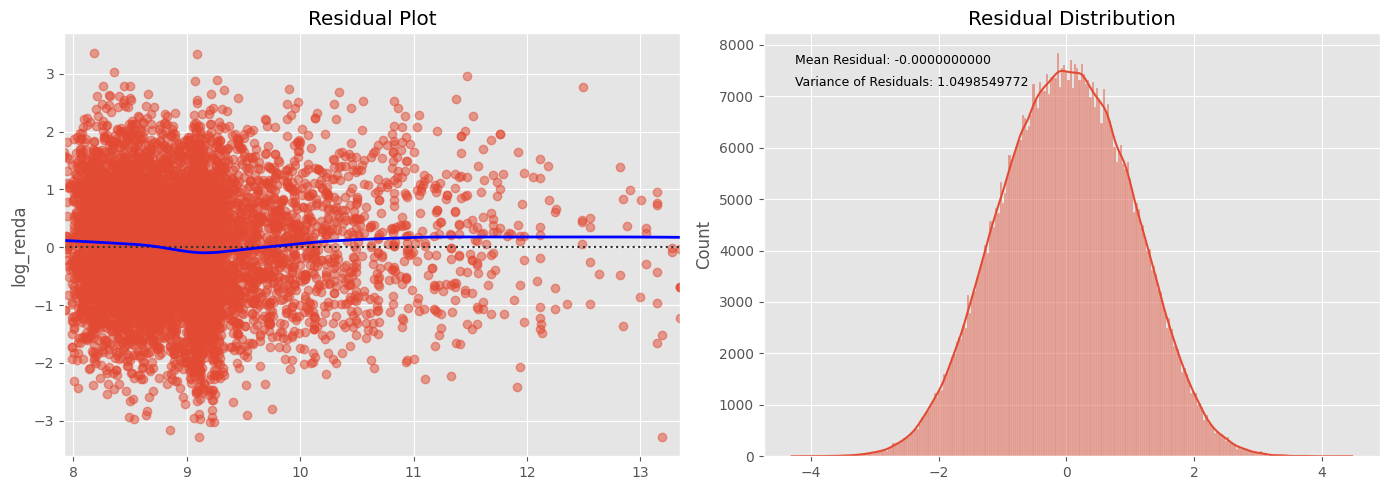

In [84]:
reg3 = smf.ols('''log_renda ~ 
    PC1
    ''', data=pca_df).fit()

sampled_data = pca_df.sample(n=7000, random_state=105)

residual_plots(reg3, sampled_data, 'log_renda')

In [85]:
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                 3.430e+05
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:18:05   Log-Likelihood:            -8.6596e+05
No. Observations:              600000   AIC:                         1.732e+06
Df Residuals:                  599998   BIC:                         1.732e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0427      0.001   6836.095      0.000       9.040       9.045
PC1            0.4477      0.001    585.675      0.000       0.446       0.449
==============================================================================
Omnibus:                     2689.307   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1994.312
Skew:                          -0.025   Prob(JB):                         0.00
Kurtosis:                       2.722   Cond. No.                         1.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
lowess = sm.nonparametric.lowess(sampled_data['log_renda'], sampled_data['PC1'], frac=2/3)
lowess_y = lowess[:, 1]
lowess_X = lowess[:, 0]

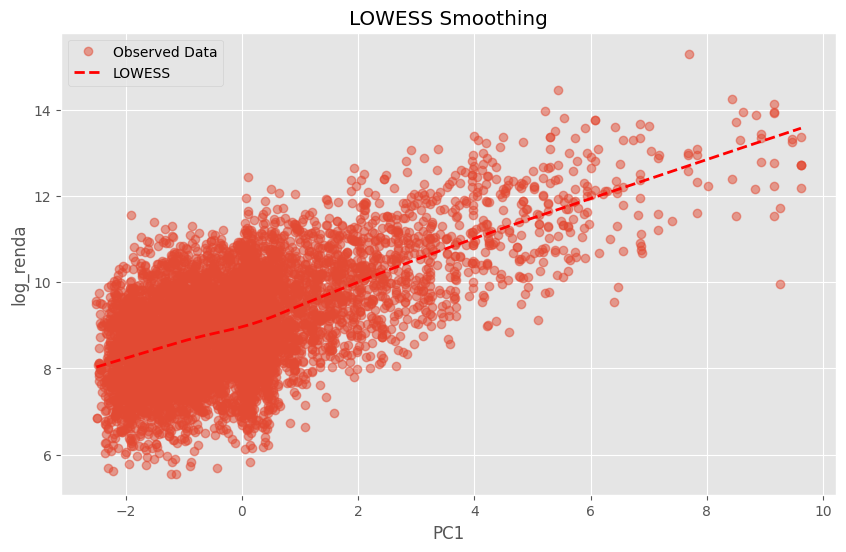

In [178]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sampled_data['PC1'], sampled_data['log_renda'], 'o', label='Observed Data', alpha=0.5)
ax.plot(lowess_X, lowess_y, 'r--', label='LOWESS', linewidth=2)
ax.set_xlabel('PC1')
ax.set_ylabel('log_renda')
ax.legend()
plt.title('LOWESS Smoothing')
plt.show()

In [184]:
f = interp1d(lowess_X, lowess_y, bounds_error=False)
pca_df['PC1_lowess'] = f(pca_df['PC1'])
pca_df.head()

,PC1,PC2,PC3,log_renda,PC1_lowess
430929,-1.006571,-0.771640,-0.225476,9.239513,8.635676
5824,1.778087,-1.120425,-0.281250,8.609088,9.877838
336875,0.025795,0.930322,-0.107754,8.937955,8.974240
568081,-1.352808,-1.457311,0.114074,8.554822,8.498162
108996,-1.681950,-0.761952,0.170103,7.924423,8.366735


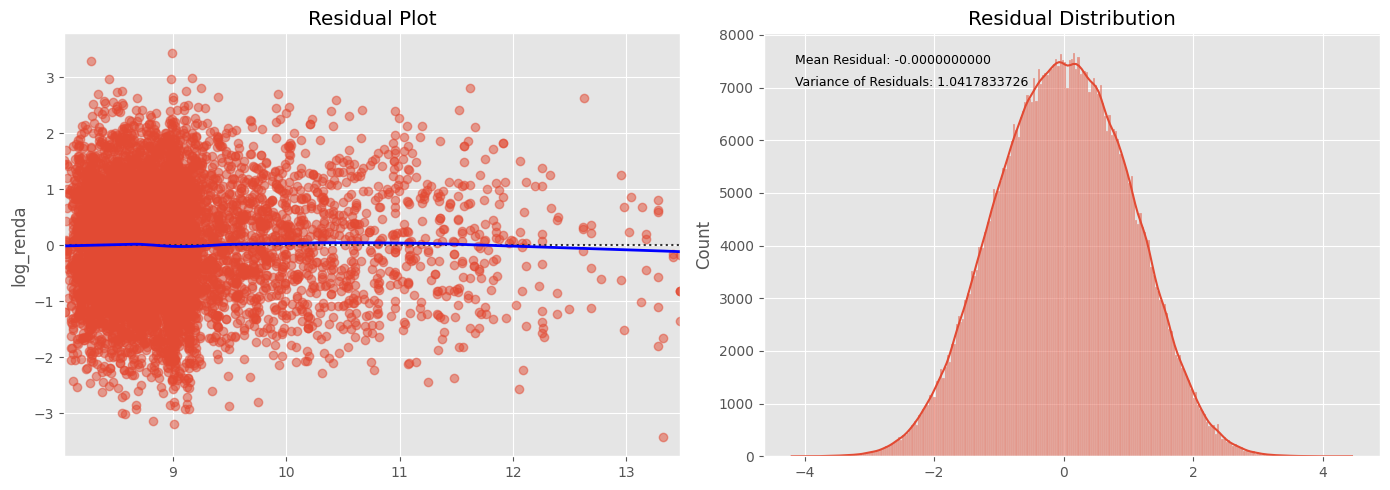

In [188]:
reg4 = smf.ols('''log_renda ~ 
    PC1_lowess
    ''', data=pca_df).fit()

sampled_data = pca_df.sample(n=7000, random_state=105)

residual_plots(reg4, sampled_data, 'log_renda')

In [202]:
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                 3.485e+05
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:13:51   Log-Likelihood:            -8.6346e+05
No. Observations:              599875   AIC:                         1.727e+06
Df Residuals:                  599873   BIC:                         1.727e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1454      0.015      9.615      0.000       0.116       0.175
PC1_lowess     0.9826      0.002    590.365      0.000       0.979       0.986
==============================================================================
Omnibus:                     2906.507   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2131.442
Skew:                          -0.026   Prob(JB):                         0.00
Kurtosis:                       2.713   Cond. No.                         106.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##dwdwd